### 3D unet

In [27]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    Lambdad,
    Activations,
    ScaleIntensityRange,
    Lambda,
    Transposed
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet, UNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric, compute_hausdorff_distance
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import numpy as np
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import nrrd
from monai.losses import SSIMLoss

In [28]:
def binarize(label, threshold=0.1):
    binary_mask = (label > threshold)
    binary_mask[binary_mask > 0] = 1  # Set all non-zero pixels to 1
    return binary_mask

In [35]:
model_type = 'unetTrans'
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

directory = os.environ.get("DATA_DIRECTORY")
root_dir = "./Test"
print(root_dir)

train_images = sorted(
    glob.glob(os.path.join(root_dir, "RVolumes", "*.nrrd")))
train_labels = sorted(
    glob.glob(os.path.join(root_dir, "RLabels", "*.nrrd")))
val_files = [{"image": image_name, "label": label_name}
            for image_name, label_name in zip(train_images, train_labels)]


val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"],
                reader="NrrdReader", image_only=True),
        Transposed(keys=['image', 'label'], indices=[2, 1, 0]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Lambdad(("label"), binarize),
        #Lambdad(("image"),binarize),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=1000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

if model_type == 'unet' or model_type == 'unetTrans':
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
else:
        model = UNETR(
        in_channels=1,
        out_channels=2,
        img_size=(128, 128, 16),
        feature_size=16,
        hidden_size=768,
        mlp_dim=3072,
        num_heads=12,
        pos_embed="perceptron",
        norm_name="instance",
        res_block=True,
        dropout_rate=0.0,
    ).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

if model_type == 'unet':
    model.load_state_dict(torch.load("./NetworkOutput/best_metric_model1200.pth"))
elif model_type == 'unetTrans':
    model.load_state_dict(torch.load(
        "/home/erattakulangara/hpchome/DeepLearningAlgo/2022_3D_Unet_segmentation/3D_Unet/ver_17.0_3D_Monai/NetworkOutput/Unet3DTrans/Models/Trans_OSIC_model_1500EP_5Layers_20Samples.pth"))
    print("Loaded Trans Unet")
else:
    model.load_state_dict(torch.load("./UnetrOutput/best_metric_model.pth"))

./Test


Loading dataset: 100%|██████████| 8/8 [00:00<00:00, 20.17it/s]

Using device: cuda
NVIDIA A10
Memory Usage:
Allocated: 0.0 GB
Cached:    0.2 GB
Loaded Trans Unet


In [36]:
train_images,train_labels


(['./Test/RVolumes/9.nrrd',
  './Test/RVolumes/P5a.nrrd',
  './Test/RVolumes/UP.nrrd',
  './Test/RVolumes/fa.nrrd',
  './Test/RVolumes/ii.nrrd',
  './Test/RVolumes/kon.nrrd',
  './Test/RVolumes/nu.nrrd',
  './Test/RVolumes/sh2.nrrd'],
 ['./Test/RLabels/9.seg.nrrd',
  './Test/RLabels/P5a.seg.nrrd',
  './Test/RLabels/UP.seg.nrrd',
  './Test/RLabels/fa.seg.nrrd',
  './Test/RLabels/ii.seg.nrrd',
  './Test/RLabels/kon.seg.nrrd',
  './Test/RLabels/nu.seg.nrrd',
  './Test/RLabels/sh2.seg.nrrd'])

In [37]:

for i, val_data in enumerate(val_loader):
    loss = loss_function(val_data["image"], val_data["label"])
    print(os.path.basename(train_images[i]),1-loss)

single channel prediction, `softmax=True` ignored.
single channel prediction, `to_onehot_y=True` ignored.


9.nrrd metatensor(0.0514)
P5a.nrrd metatensor(0.0440)
UP.nrrd metatensor(0.0432)
fa.nrrd metatensor(0.0506)
ii.nrrd metatensor(0.0535)
kon.nrrd metatensor(0.0456)
nu.nrrd metatensor(0.0408)
sh2.nrrd metatensor(0.0422)


torch.Size([1, 2, 256, 256, 36]) torch.Size([1, 1, 256, 256, 36])
torch.Size([256, 256, 36])


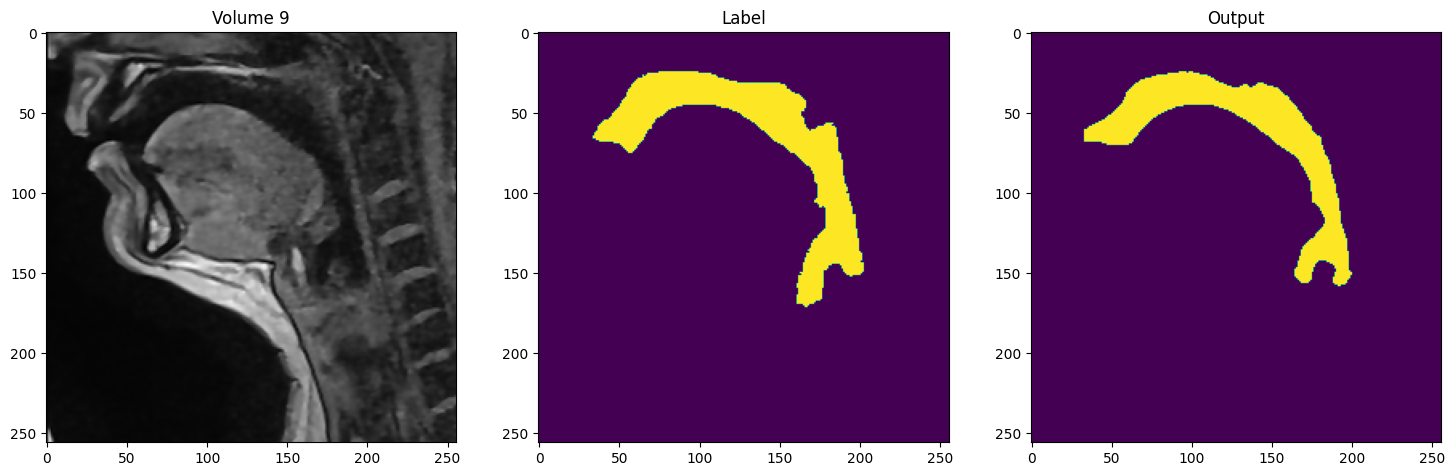

torch.Size([1, 2, 256, 256, 36]) torch.Size([1, 1, 256, 256, 36])
torch.Size([256, 256, 36])


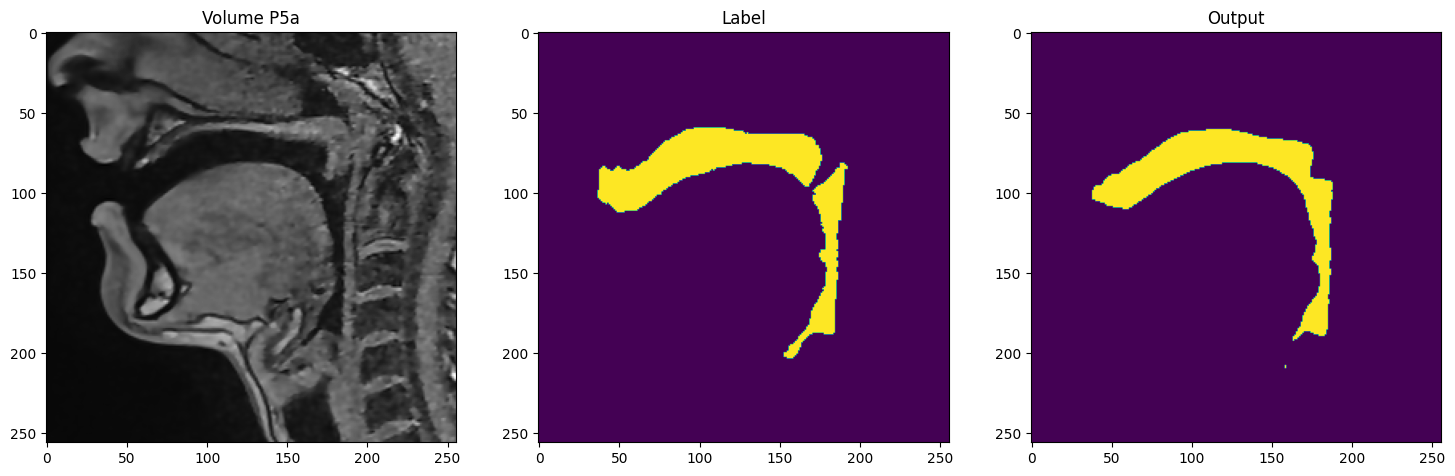

torch.Size([1, 2, 256, 256, 36]) torch.Size([1, 1, 256, 256, 36])
torch.Size([256, 256, 36])


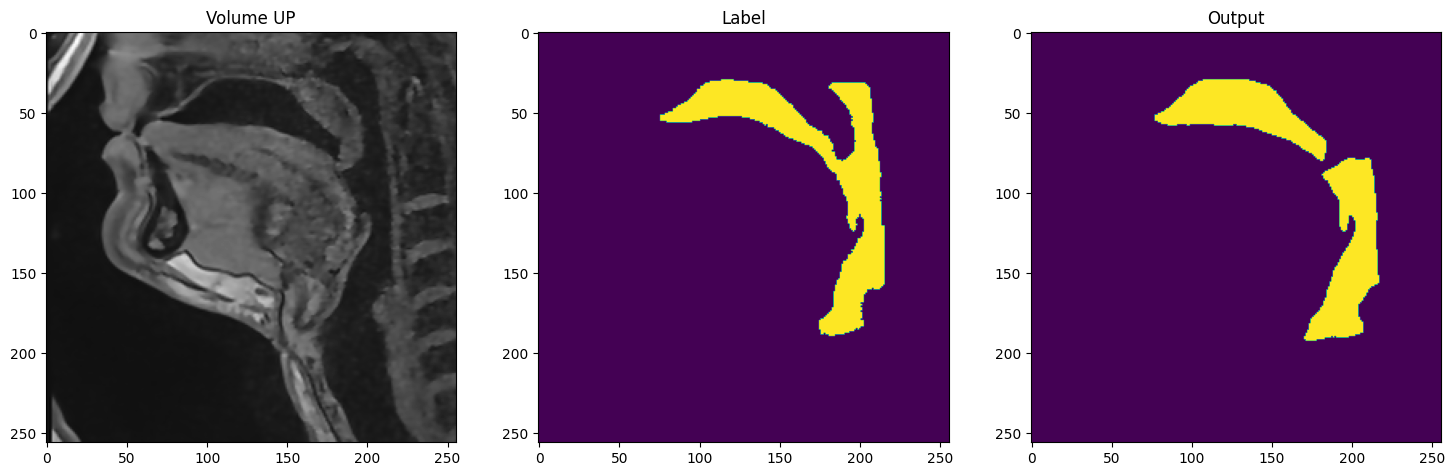

torch.Size([1, 2, 256, 256, 36]) torch.Size([1, 1, 256, 256, 36])
torch.Size([256, 256, 36])


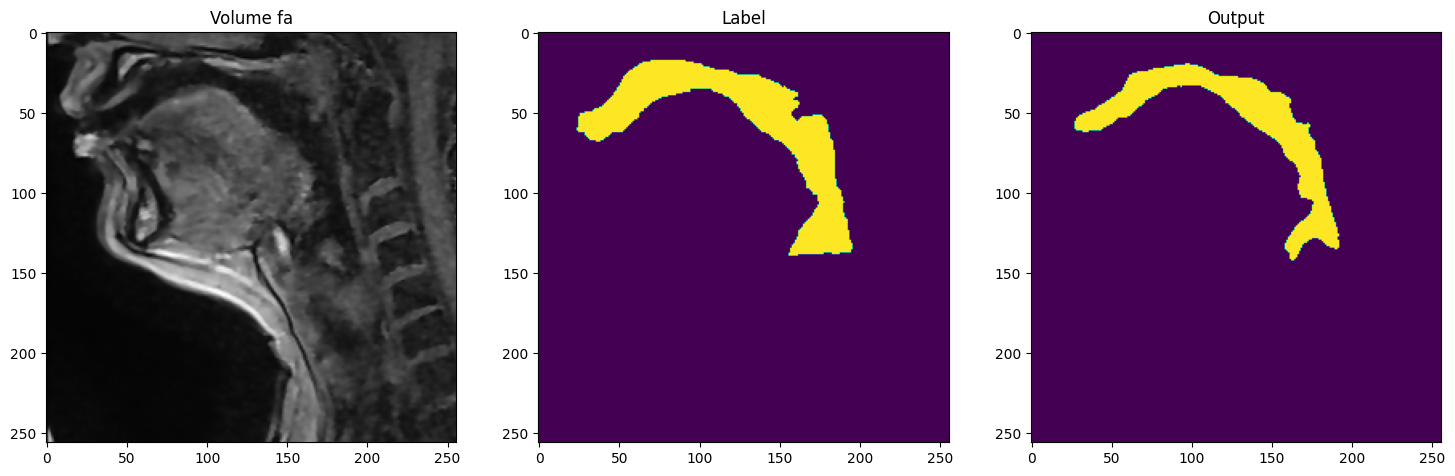

torch.Size([1, 2, 256, 256, 36]) torch.Size([1, 1, 256, 256, 36])
torch.Size([256, 256, 36])


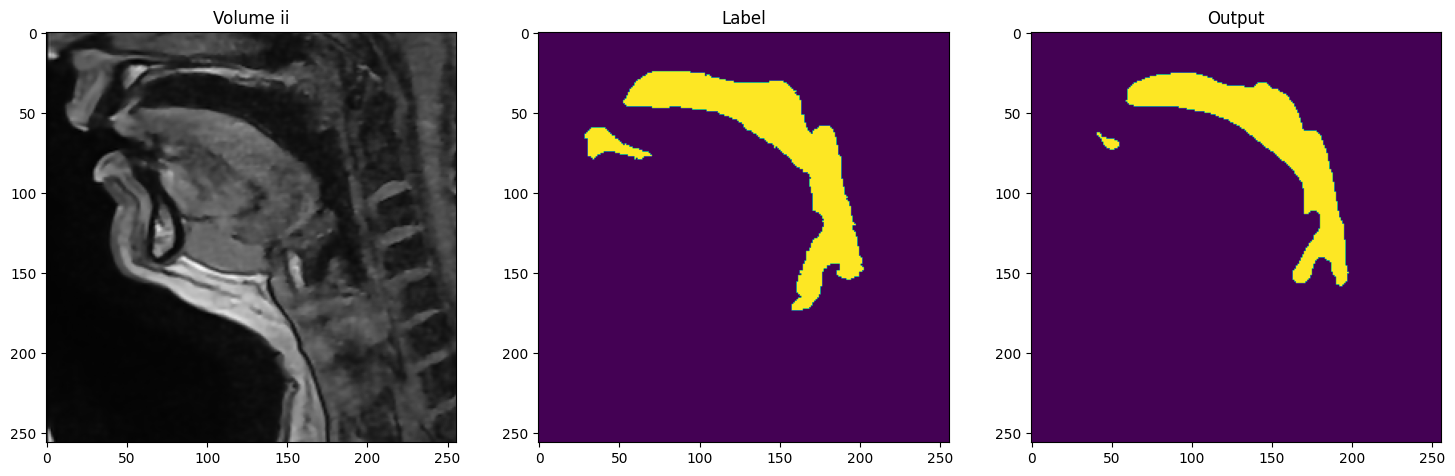

torch.Size([1, 2, 256, 256, 36]) torch.Size([1, 1, 256, 256, 36])
torch.Size([256, 256, 36])


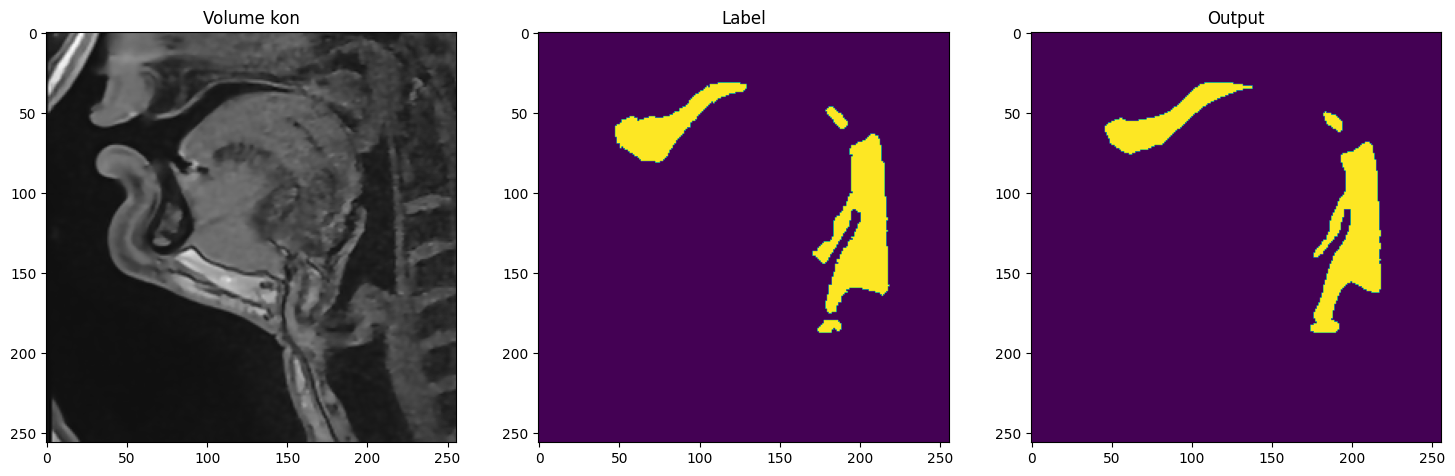

torch.Size([1, 2, 256, 256, 36]) torch.Size([1, 1, 256, 256, 36])
torch.Size([256, 256, 36])


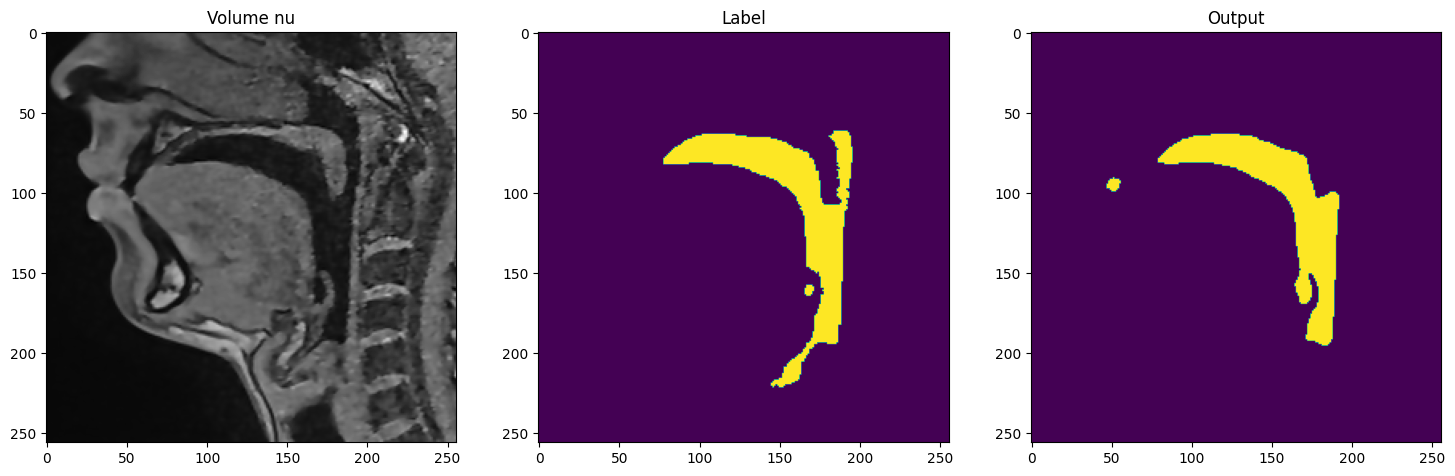

torch.Size([1, 2, 256, 256, 36]) torch.Size([1, 1, 256, 256, 36])
torch.Size([256, 256, 36])


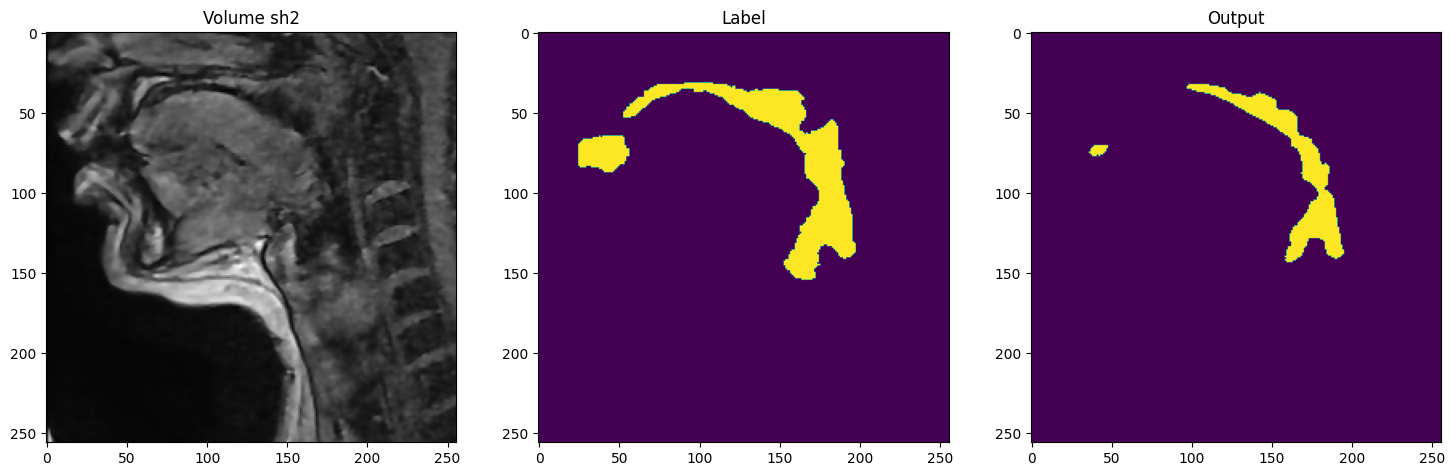

In [38]:
dice_metric = DiceMetric(include_background=True, reduction="none")
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (128, 128, 16)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model)
        #dice_metric(y_pred=val_outputs[0][0], y=val_data["label"][0][0].to(device))
        #print('hausedorff ',compute_hausdorff_distance(y_pred=val_outputs[0][0].transpose(2,0,1), y=val_data["label"][0][0].transpose(2,1,0).to(device)))
        #loss = loss_function(val_outputs,val_data["label"].to(device))
        print(val_outputs.shape, val_data["label"].shape)
        #loss = 1-SSIMLoss(spatial_dims=2)(val_outputs[0,:1,:,:,:],val_data["label"][0,:1,:,:,:].to(device))
        #print(loss)
        # print(dice_metric.aggregate())
        # dice_metric.reset()
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"Volume {os.path.basename(train_images[i]).replace('.nrrd','')}")
        plt.imshow(val_data["image"][0, 0, :, :, 15], cmap="gray")

        plt.subplot(1, 3, 2) 
        plt.title(f"Label")
        plt.imshow(val_data["label"][0, 0, :, :, 15])

        plt.subplot(1, 3, 3)
        plt.title(f"Output")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 15])
        print(torch.argmax(val_outputs,dim=1)[0].shape)

        if model_type == 'unet':
            out_path = "./NetworkOutput/3DUnet/"
            #plt.savefig(os.path.join("./NetworkOutput/3DUnet/", f"modelOutput{i}.jpg"))
            #nrrd.write(os.path.join(out_path, os.path.basename(train_images[i])), torch.argmax(
                #val_outputs, dim=1)[0].cpu().detach().numpy())
        elif model_type == 'unetTrans':
            out_path = "./NetworkOutput/Unet3DTrans/Output/20-Samples/"
            plt.savefig(os.path.join(out_path, f"modelOutput{i}.jpg"))
        else:
            out_path = "./NetworkOutput/UnetR/"
            #plt.savefig(os.path.join("./NetworkOutput/UnetR/", f"modelOutput{i}.jpg"))
            #nrrd.write(os.path.join(out_path, os.path.basename(train_images[i])), torch.argmax(
            #    val_outputs, dim=1)[0].cpu().detach().numpy())
        plt.show()
        


In [59]:
print(np.max(val_data["label"]))

True


In [ ]:
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        print(val_data["image"].shape)
        plt.imshow(val_data["label"][0][0][:,:,10])
        break

### Save image overlays

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import nrrd

In [189]:

volumep = "./Test/2D-Unet/"
labelp = "./Test/RLabels/"
volumes = sorted(
    glob.glob(os.path.join(volumep, "*.nrrd")))
labels = sorted(
    glob.glob(os.path.join(labelp, "*.nrrd")))


In [190]:
labels, volumes

(['./Test/RLabels/9.seg.nrrd',
  './Test/RLabels/P5a.seg.nrrd',
  './Test/RLabels/UP.seg.nrrd',
  './Test/RLabels/fa.seg.nrrd',
  './Test/RLabels/ii.seg.nrrd',
  './Test/RLabels/kon.seg.nrrd',
  './Test/RLabels/nu.seg.nrrd',
  './Test/RLabels/sh2.seg.nrrd'],
 ['./Test/2D-Unet/9.nrrd',
  './Test/2D-Unet/P5a.nrrd',
  './Test/2D-Unet/UP.nrrd',
  './Test/2D-Unet/fa.nrrd',
  './Test/2D-Unet/ii.nrrd',
  './Test/2D-Unet/kon.nrrd',
  './Test/2D-Unet/nu.nrrd',
  './Test/2D-Unet/sh2.nrrd'])

In [198]:
from monai.metrics import DiceMetric, compute_hausdorff_distance
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
def one_hot_encode(array):
    print(array.shape)
    print(np.eye(2)[array].shape)#.transpose(3,0, 1, 2)[None].shape)
    return np.eye(2)[array].astype(dtype=int).transpose(3, 0, 1, 2)[None]



for i,sample in enumerate(volumes):
    volume_data, volume_header = nrrd.read(sample)
    mask_data, mask_header = nrrd.read(labels[i])
    v = volume_data#.transpose(2,0,1)
    m = mask_data.transpose(0,2,1)
    #v = torch.from_numpy(v[4:36, :, :])
    v = torch.from_numpy(v[:,:,:])
    m = torch.from_numpy(m[:, :, :])
    print("v", v.shape, "m", m.shape)
    loss = compute_hausdorff_distance(one_hot_encode(v), one_hot_encode(
        m), include_background=False, distance_metric='euclidean')
    print(os.path.basename(volumes[i]), loss)
    #plt.axis('off')
    #plt.imshow(v[15, :, :], cmap='gray')  # I would add interpolation='none'
    #plt.imshow(m[12, :, :], cmap='jet', alpha=0.4*(m[12, :, :] > 0))
    # plt.savefig(os.path.join("./Figures/Volume/", os.path.basename(sample) +
    #             ".png"), bbox_inches='tight', pad_inches=0)
    


v torch.Size([32, 256, 256]) m torch.Size([32, 256, 256])
torch.Size([32, 256, 256])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [70]:
labels

['./Test/RLabels/9.seg.nrrd',
 './Test/RLabels/P5a.seg.nrrd',
 './Test/RLabels/UP.seg.nrrd',
 './Test/RLabels/fa.seg.nrrd',
 './Test/RLabels/ii.seg.nrrd',
 './Test/RLabels/kon.seg.nrrd',
 './Test/RLabels/nu.seg.nrrd',
 './Test/RLabels/sh2.seg.nrrd']

In [34]:
volume_data, volume_header = nrrd.read(volume)
mask_data, mask_header = nrrd.read(label)


In [35]:
volume_data.shape, mask_data.shape

((36, 256, 256), (32, 256, 256))

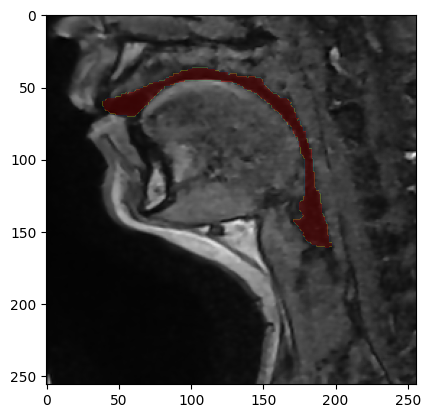

In [65]:
v = np.moveaxis(volume_data, 0, -1)
v = np.moveaxis(volume_data, -1, 1)
m = np.moveaxis(mask_data, 0, -1)
m = np.moveaxis(mask_data, -1, 1)
plt.imshow(v[10,:,:], cmap='gray') # I would add interpolation='none'
plt.imshow(m[6,:,:], cmap='jet', alpha=0.4*(m[6,:,:]>0)   )

### single image overlays

In [84]:
volume = "Test/RVolumes/9.nrrd"
label = "./NetworkOutput/3DUnet/9.nrrd"
volume_data, volume_header = nrrd.read(volume)
mask_data, mask_header = nrrd.read(label)


In [85]:
volume_data.shape, mask_data.shape


((36, 256, 256), (256, 256, 36))

In [86]:
print(np.max(mask_data))

1


v (36, 256, 256) m (36, 256, 256)


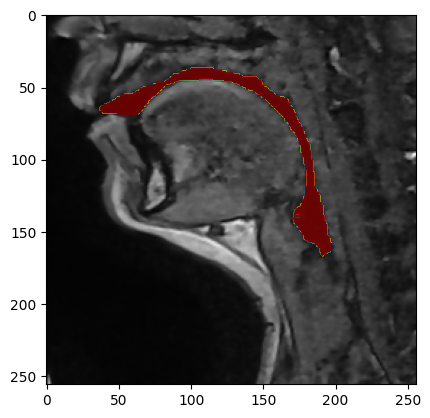

In [90]:
v = volume_data.transpose(0,2,1)
m = mask_data.transpose(2,0,1)
print("v", v.shape, "m", m.shape)
plt.imshow(v[10,:,:], cmap='gray') # I would add interpolation='none'
plt.imshow(m[10,:,:], cmap='jet',alpha=0.8*(m[10,:,:]>0.1)   )

In [9]:
import numpy as np
import nrrd
filename_vds_osa = ['./results_espirit_9_2espiritarms_5latVec800frms_10_Geph39_feph_sl10.npy']
filename_vds_osa_sl08 = ['sl10.nrrd']


In [10]:
for i,files in enumerate(filename_vds_osa):
    data_vds_osa = np.abs(np.load(files))
    print(data_vds_osa.shape)
    nrrd.write(filename_vds_osa_sl08[i], data_vds_osa)


(800, 320, 320)
